In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import pandas as pd
import os


In [7]:
#dataset folder
data_dir = "Datasets"

#paths and labels
image_paths = []
labels = []

#labels to integers
class_mapping = {
    "Melanocytic_Nevi": 1,
    "Benign_Keratosis_like_Lesions": 2,
    "NormalSkin": 3
}

In [8]:
for class_name, class_label in class_mapping.items():
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg"):  # Assuming your images are in JPG format
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(class_label)

#image paths and labels
data = pd.DataFrame({"image_path": image_paths, "label": labels})

#train, test, and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [9]:
#augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
)


valid_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [10]:
# string format DataFrame
train_data["label"] = train_data["label"].astype(str)
valid_data["label"] = valid_data["label"].astype(str)
test_data["label"] = test_data["label"].astype(str)

batch_size = 32 

#class_mode set to "categorical"
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_data,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = valid_datagen.flow_from_dataframe(
    test_data,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical"
)


Found 6508 validated image filenames belonging to 3 classes.
Found 1628 validated image filenames belonging to 3 classes.
Found 2035 validated image filenames belonging to 3 classes.


In [11]:
#ResNet50 model with pre-trained weights and exclude the top layer
base_model = ResNet50(weights='imagenet', include_top=False)

#classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes

#final model
model = Model(inputs=base_model.input, outputs=predictions)


for layer in model.layers[:100]:
    layer.trainable = True



In [14]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers

new_learning_rate = 0.00001 
optimizer = legacy_optimizers.Adam(learning_rate=new_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
epochs = 10  

history = model.fit(train_generator,
                    steps_per_epoch=len(train_data) // batch_size,
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=len(valid_data) // batch_size)


Epoch 1/10
203/203 [==============================] - 926s 5s/step - loss: 0.2726 - accuracy: 0.8905 - val_loss: 4.0191 - val_accuracy: 0.1981
Epoch 2/10
203/203 [==============================] - 936s 5s/step - loss: 0.1729 - accuracy: 0.9324 - val_loss: 2.6318 - val_accuracy: 0.2106
Epoch 3/10
203/203 [==============================] - 964s 5s/step - loss: 0.1414 - accuracy: 0.9458 - val_loss: 0.8149 - val_accuracy: 0.4831
Epoch 4/10
203/203 [==============================] - 1328s 7s/step - loss: 0.1161 - accuracy: 0.9551 - val_loss: 0.4608 - val_accuracy: 0.7987
Epoch 5/10
203/203 [==============================] - 871s 4s/step - loss: 0.0919 - accuracy: 0.9643 - val_loss: 0.2569 - val_accuracy: 0.9131
Epoch 6/10
203/203 [==============================] - 899s 4s/step - loss: 0.0750 - accuracy: 0.9731 - val_loss: 0.1244 - val_accuracy: 0.9588
Epoch 7/10
203/203 [==============================] - 836s 4s/step - loss: 0.0664 - accuracy: 0.9765 - val_loss: 0.1103 - val_accuracy: 0.965

In [16]:
final_accuracy = history.history['accuracy'][-1]
final_loss = history.history['loss'][-1]

print(f'Final Training Accuracy: {final_accuracy}')
print(f'Final Training Loss: {final_loss}')


Final Training Accuracy: 0.9844039678573608
Final Training Loss: 0.044705670326948166


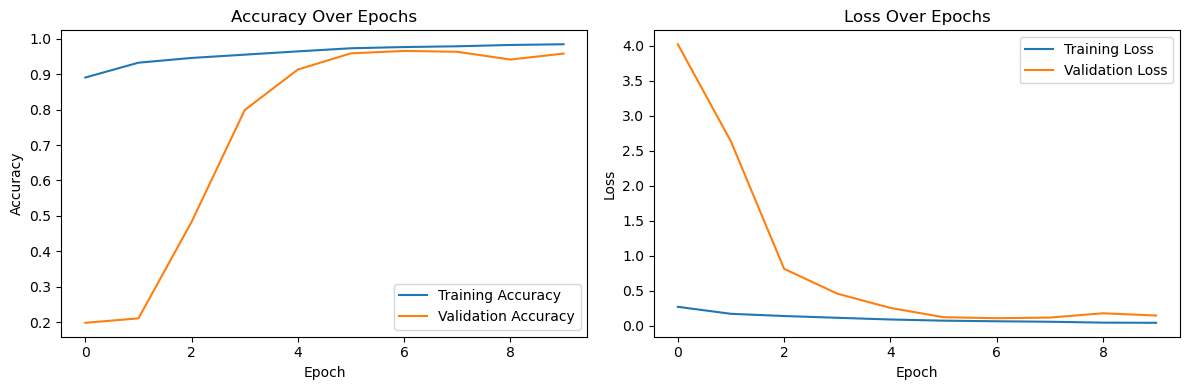

In [17]:
import matplotlib.pyplot as plt


training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

#subplots for accuracy and loss
plt.figure(figsize=(12, 4))

#Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

#Plot loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')


plt.tight_layout()
plt.show()


In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')


64/64 [==============================] - 57s 885ms/step - loss: 0.1634 - accuracy: 0.9479
Test Accuracy: 0.9479115605354309
Test Loss: 0.16336145997047424
